In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

import pickle
from bitarray import bitarray

In [2]:
class Filter_banks():
    def __init__(self, x, N=512):
        self.x = x
        self.N = N
        self.n = np.arange(2*N)
        self.h_k = np.zeros((N, 2*N))
        self.g_k = np.zeros((N, 2*N))
        self.y1 = np.zeros((N, len(x)))
        self.y2 = np.zeros((N, len(x)//N))
        self.s = 0  # (N-1) is identical to mode="same"

    def analysis(self):
        # filter and downsample
        self.h_n = np.sin(np.pi*(self.n + 0.5) /2 /self.N) * np.sqrt(2/self.N)
        for k in range(self.N):
            self.g_k[k, :] = self.h_n * np.cos(np.pi*(k+0.5)*(self.n+0.5-0.5*self.N) /self.N)
            self.h_k[k, :] = self.g_k[k, ::-1]
            self.y1[k, :] = signal.convolve(self.x, self.h_k[k, :], mode="full")[self.s:len(self.x)+self.s]  # filtering
            self.y2[k, :] = self.y1[k, k::self.N]   # downsampling

    def synthesis(self, new_y2=None):
        # restore
        if new_y2 is not None:
            self.new_y2 = np.array(new_y2)
        else:
            self.new_y2 = np.array(self.y2)
        self.y3 = np.zeros((self.N, len(self.x)))
        self.y4 = np.zeros((self.N, len(self.x)))
        for k in range(self.N):
            self.y3[k, k::self.N] = self.new_y2[k, :]  # upsampling
            self.y4[k, :] = signal.convolve(self.y3[k, :], self.g_k[k, :], mode="full")[self.s:len(self.x)+self.s] # filtering
        self.x_hat = self.y4.sum(0)
        return self.x_hat

In [3]:
class TreeNode:
    def __init__(self, value, symbols):
        self.value = value
        self.symbols = symbols
        self.left = None
        self.right = None
        self.parent_from_left = None
        self.parent_from_right = None
    
    def __repr__(self):
        return str(self.value)

In [4]:
key = lambda x: x.value

class Huffman:
    # only encoding here
    def __init__(self, string):
        self.string = string
        self.symbols_dict = {}
        for s in self.string:
            if s in self.symbols_dict:
                self.symbols_dict[s] += 1
            else:
                self.symbols_dict[s] = 1
        self.routines()
                
    def routines(self):
        self.__tree()
        self.__backward()
        
    def __tree(self):
        self.sorted_dict = dict(sorted(self.symbols_dict.items(), key=lambda item: item[1]))
        #self.cod_dict = dict.fromkeys(self.symbols_dict.keys())
        #for k, v in self.sorted_dict.items():
        #    ba = bitarray()
            
        self.cod_dict = dict.fromkeys(self.symbols_dict.keys())
        self.nodes = [[]]
        for s in self.sorted_dict:
            self.nodes[-1].append(TreeNode(self.symbols_dict[s], s))
        self.nodes[-1] = sorted(self.nodes[-1], key=key)
        k = 0
        while (len(self.nodes[-1]) > 1) and (k < 256):
            k += 1
            #print(self.nodes)
            new_value = self.nodes[-1][0].value + self.nodes[-1][1].value
            #print((self.nodes[-1][0].symbols))
            new_symbols = [self.nodes[-1][0].symbols] + [self.nodes[-1][1].symbols]
            new_node = TreeNode(new_value, new_symbols)
            new_node.left = self.nodes[-1][0]
            new_node.right = self.nodes[-1][1]
            self.nodes[-1][0].parent_from_left = new_node
            self.nodes[-1][1].parent_from_right = new_node
            new_nodes = [new_node] + self.nodes[-1][2:]
            self.nodes.append(sorted(new_nodes, key=key))
            
    def __backward(self):
        #print('sorted_dict:', self.sorted_dict)
        for i, s in enumerate(self.sorted_dict):
            x = self.nodes[0][i]
            cod = ''
            #print('len_dict:', len(self.sorted_dict))
            for k in range(len(self.sorted_dict)):
                if x.parent_from_left:
                    x = x.parent_from_left
                    if x is None:
                        break
                    cod += '0'
                else:
                    x = x.parent_from_right
                    if x is None:
                        break
                    cod += '1'
            self.cod_dict[s] = cod[::-1]
        
    def encode(self):
        from bitarray import bitarray
        
        self.decod_dict = {v: np.int8(k) for k, v in self.cod_dict.items()}
        output = ''
        #print('len:', len(self.string))
        for s in self.string:
            coded_s = self.cod_dict[s]
            output += coded_s
        #print('output:', output)
        self.coded_string = bitarray(output)
        return self.decod_dict, self.coded_string

In [43]:
def decode1(decod_dicts, steps, coded_strings, lens):
    decoded_y2 = np.zeros_like(fb.y2)
    decoded_y2_8bit = np.zeros_like(fb.y2)
    r = 0
    for i in range(N):
        #print(decode2(decod_dicts[i], coded_strings[r:r+lens[i]]).shape)
        decoded_y2_8bit[i, :] = decode2(decod_dicts[i], coded_strings[r:r+lens[i]]) #[:fb.y2.shape[1]] #todo
        decoded_y2[i, :] = decoded_y2_8bit[i, :] * steps[i]
        r += lens[i]
    x_hat = fb.synthesis(decoded_y2)
    return x_hat

def decode2(decod_dict, data):
    #ba = bitarray()
    #ba.frombytes(data)
    #print('ba:', ba)
    ba = data
    #print(len(ba))

    restored = []
    buffer = ''
    #b
    for i, s in enumerate(ba):
        buffer += str(s)
        #print(buffer)
        #if decod_dict.get(buffer):
        if buffer in decod_dict:
            restored.append(decod_dict[buffer])
            buffer = ''
    return np.array(restored)

In [97]:
from scipy.io import wavfile
audiofile = "Track16.wav"
test_bin = "test.bin"
original_mdct = "original_mdct.bin"
encoded_mdct = "encoded_mdct.bin"

fs, data = wavfile.read(audiofile)

start = 10_000
N = 32  # bands
duration = 400_000 # in samples

x = data[start:start+duration, :]

#fb = Filter_banks(x, N)
#fb.analysis()

In [98]:
def main(x):
    global fb
    fb = Filter_banks(x, N)
    fb.analysis()
    decod_dicts = []
    steps = []
    lens = []
    #coded_strings = []
    coded_strings = bitarray()
    data8bits = []
    for i in range(N):
        step_size = (float(np.max(fb.y2[i, :])) - float(np.min(fb.y2[i, :]))) / 2**8
        data8bit = (fb.y2[i, :] / step_size).astype(np.int8)
        data8bits.append(data8bit)
        huffman = Huffman(data8bit)
        decod_dict, coded_string = huffman.encode()
        decod_dicts.append(decod_dict)
        #coded_strings.append(coded_string.tobytes())
        #coded_strings.append(coded_string)
        lens.append(len(coded_string))
        coded_strings.extend(coded_string)
        steps.append(step_size)
    return steps, decod_dicts, coded_strings, data8bits, lens

In [99]:
steps, decod_dicts, coded_strings, data8bits, lens = main([*x[:, 0], *x[:, 1]])

In [100]:
pickle.dump([steps, data8bits], open(original_mdct, "wb"), 1)
pickle.dump([steps, decod_dicts, coded_strings, lens], open(encoded_mdct, "wb"), 1)

print(os.path.getsize(original_mdct) / 1024)
print(os.path.getsize(encoded_mdct) / 1024)

981.0146484375
749.6015625


In [101]:
[steps_hat, decod_dicts_hat, coded_strings_hat, lens] = pickle.load(open(encoded_mdct, "rb"))

In [102]:
a = decode1(decod_dicts_hat, steps_hat, coded_strings_hat, lens)

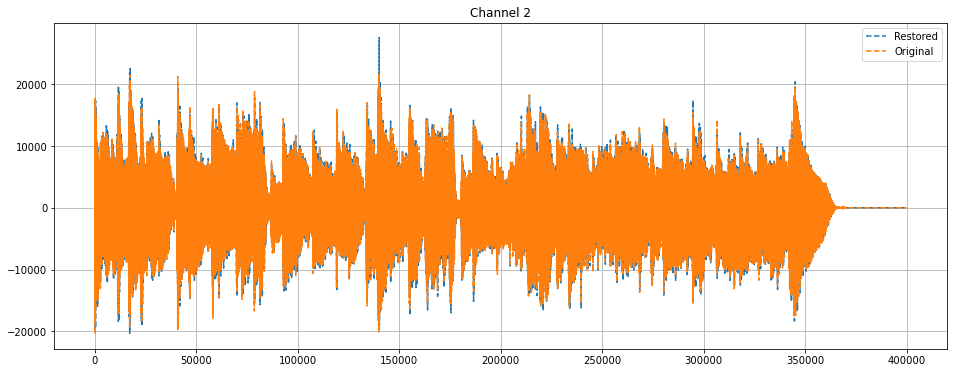

In [103]:
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot()
ax.plot(a[:len(a)//2], '--')
ax.plot(x[:, 0], '--')
plt.legend(['Restored', 'Original'])
plt.grid()
plt.title("Channel 2")
plt.show()

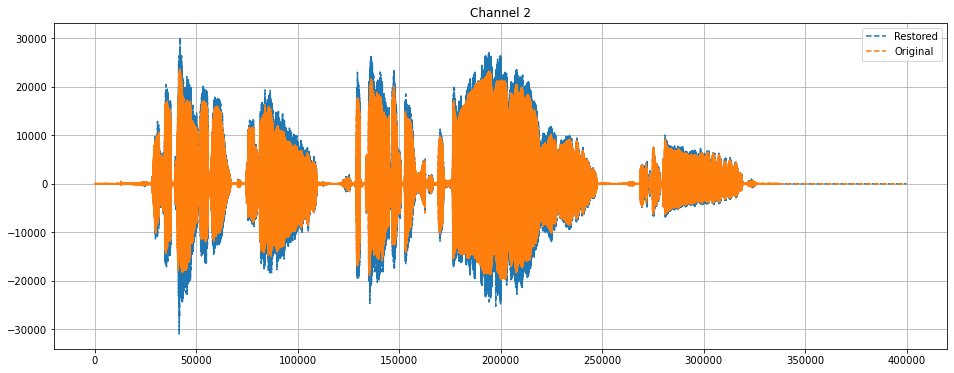

In [104]:
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot()
ax.plot(a[len(a)//2:], '--')
ax.plot(x[:, 1], '--')
plt.legend(['Restored', 'Original'])
plt.grid()
plt.title("Channel 2")
plt.show()

In [47]:
steps1, decod_dicts1, coded_strings1, data8bits1, lens1 = main(data[start:start+duration, 0])
steps2, decod_dicts2, coded_strings2, data8bits2, lens2 = main(data[start:start+duration, 1])

In [48]:
pickle.dump([steps1, data8bits1, lens1, steps2, data8bits2, lens2], open(original_mdct, "wb"), 1)

import os
print(os.path.getsize(original_mdct) / 1024)

1019.6416015625


In [49]:
pickle.dump([steps1, coded_strings1, lens1, steps2, coded_strings2, lens2], open(encoded_mdct, "wb"), 1)

print(os.path.getsize(encoded_mdct) / 1024)

634.3125


In [50]:
pickle.dump([steps1, decod_dicts1, coded_strings1, lens1, 
             steps2, decod_dicts2, coded_strings2, lens2], open(encoded_mdct, "wb"), 1)

print(os.path.getsize(encoded_mdct) / 1024)
# 95.7 kB
# 16 * 1000 * 8 / 8 / 1000 kB = 16

853.8115234375


In [51]:
[steps1_hat, decod_dicts1_hat, coded_strings1_hat, lens1,
 steps2_hat, decod_dicts2_hat, coded_strings2_hat, lens2] = pickle.load(open(encoded_mdct, "rb"))

#decoded_y2_8bit = np.zeros_like(fb.y2)
a = decode1(decod_dicts1_hat, steps1_hat, coded_strings1_hat, lens1)

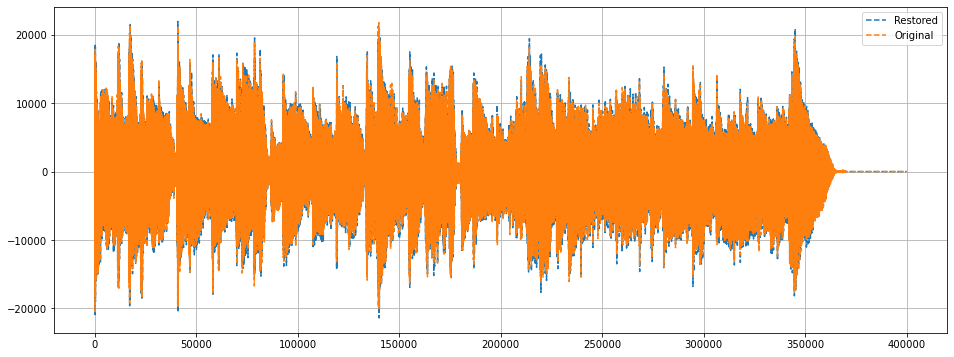

In [52]:
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot()
ax.plot(a, '--')
ax.plot(x[:, 0], '--')
plt.legend(['Restored', 'Original'])
plt.grid()
#plt.title()
plt.show()

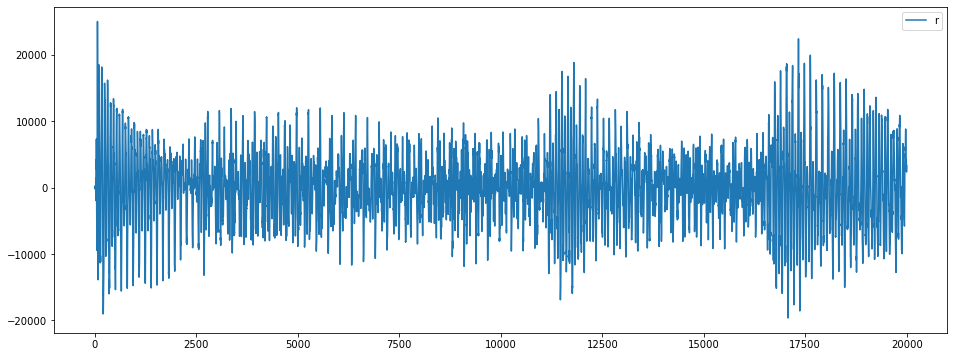

In [74]:
fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot()
a xplot(a)
plt.legend(['r', 'o'])
plt.show()

In [264]:
#[steps1_hat, coded_strings1_hat, 
 #steps2_hat, coded_strings2_hat] = pickle.load(open(encoded_mdct, "rb"))

In [34]:
c = bitarray('1001011')
c.extend(bitarray('10'))
c[:5]

bitarray('10010')

In [42]:
ba = bitarray('0011011010010000010100001110000000111')
len(ba)
len(ba.tobytes())

5

In [43]:
len(coded_strings[0]) #ba

7178

In [45]:
len(coded_strings[0]) # bytes

898

In [141]:
decoded_y2_8bit = np.zeros_like(fb.y2)
decoded_y2 = np.zeros_like(fb.y2)
for i in range(N):
    #print(decod_dicts[i], coded_strings[i])
    #print(decode(decod_dicts[i], coded_strings[i]).shape)
    decoded_y2_8bit[i, :] = decode(decod_dicts[i], coded_strings[i])
    #print(decoded_y2_8bit)
    decoded_y2[i, :] = decoded_y2_8bit[i, :] * steps[i]
#fb.y2 = np.array(decoded_y2)
x_hat = fb.synthesis(decoded_y2)

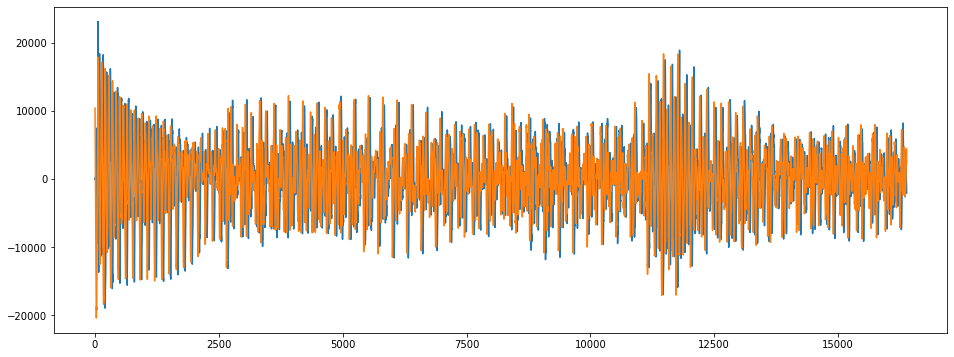

In [145]:
decoded_y2.shape

fig = plt.figure(figsize = (16, 6))
ax = fig.add_subplot()
#ax.plot(decoded_y2[0, :])
ax.plot(x_hat)
ax.plot(x)
plt.show()

In [89]:
# for check
import pickle
from bitarray import bitarray
test_bin = "test.bin"
#string = np.array([1, -3, 5, 3, 3, 10, 12, 16, -14, 3, 12]).astype(np.int8)
string = np.arange(22)
#string = fb.y2[i, :].astype(np.int8)
huf1 = Huffman(string)

decod_dict, coded_string = huf1.encode()
decode(decod_dict, coded_string)


len: 22
output: 000001011001110100010101001100000111011110010110101011100010011110111111001101


array([ 8,  9,  7,  9, 10, 12,  6, 13,  9, 12,  8, 11,  7, 10,  6, 10, 13,
        7, 12,  6,  7, 10, 11, 11,  9, 13])

In [90]:
huf1.cod_dict
#decod_dict, coded_string

{0: '000',
 1: '001',
 2: '0110',
 3: '0111',
 4: '0100',
 5: '0101',
 6: '010',
 7: '011',
 8: '000',
 9: '001',
 10: '110',
 11: '111',
 12: '100',
 13: '101',
 14: '1010',
 15: '1011',
 16: '1000',
 17: '1001',
 18: '1110',
 19: '1111',
 20: '1100',
 21: '1101'}

In [50]:
# for check
decod_dict, coded_string = huf1.encode()
size = pickle.dump([decod_dict, coded_string.tobytes()], open(test_bin, "wb"), 1)
#size = pickle.dump(coded_string.tobytes(), open(test_bin, "wb"), 1)
#decod_dict, coded_string

decod_dict_dec, data = pickle.load(open(test_bin, "rb"))
decod_dict_dec, data
decode(decod_dict_dec, data)

len: 5
output: 1101111000


array([], dtype=float64)

In [117]:
bb = bitarray(endian='big')
bb.frombytes((string[0]).tobytes())
#(3).to_bytes(1, byteorder='big')

In [13]:
#pip install import-ipynb

import import_ipynb
import sys
sys.path.insert(0, '../HW2')
from hw2 import Filter_banks

In [143]:
fb.y2.shape

(16, 320)

In [38]:
huf1.cod_dict

{'b': '00',
 'e': '11',
 'p': '101',
 ' ': '010',
 'o': '011',
 'r': '1000',
 '!': '1001'}

In [40]:
decod_dict_dec, data

({'00': 'b',
  '11': 'e',
  '101': 'p',
  '010': ' ',
  '011': 'o',
  '1000': 'r',
  '1001': '!'},
 b'>\xa1\xba\x8f\x89')

In [2]:
# OLD
# calculate dict
symbols_dict = {}
string = "beep boop beer!"
for s in string:
    if s in symbols_dict:
        symbols_dict[s] += 1
    else:
        symbols_dict[s] = 1
symbols_dict

{'b': 3, 'e': 4, 'p': 2, ' ': 2, 'o': 2, 'r': 1, '!': 1}

In [62]:
# filter banks and quantisation
import sys
import io, os, sys, types
from IPython import get_ipython
from nbformat import read
from IPython.core.interactiveshell import InteractiveShell

#sys.path.insert(0, '../HW2')
sys.path.insert(0, '/home/ainur/Study/GRIAT_3/AC/Golokolenko/AC_Homeworks/HW2')


In [3]:
sorted_dict = dict(sorted(symbols_dict.items(), key=lambda item: item[1]))
cod_dict = dict.fromkeys(symbols_dict.keys())

In [8]:
key = lambda x: x.value
nodes[-1] = sorted(nodes[-1], key=key)

In [9]:
k = 0
while (len(nodes[-1]) > 1) and (k < 20):
    k += 1
    new_value = nodes[-1][0].value + nodes[-1][1].value
    new_symbols = list(nodes[-1][0].symbols) + list(nodes[-1][1].symbols)
    new_node = TreeNode(new_value, new_symbols)
    new_node.left = nodes[-1][0]
    new_node.right = nodes[-1][1]
    nodes[-1][0].parent_from_left = new_node
    nodes[-1][1].parent_from_right = new_node
    new_nodes = [new_node] + nodes[-1][2:]
    nodes.append(sorted(new_nodes, key=key))

In [10]:
nodes

[[1, 1, 2, 2, 2, 3, 4],
 [2, 2, 2, 2, 3, 4],
 [2, 2, 3, 4, 4],
 [3, 4, 4, 4],
 [4, 4, 7],
 [7, 8],
 [15]]

In [11]:
for i, s in enumerate(sorted_dict):
    x = nodes[0][i]
    cod = ''
    for k in range(len(sorted_dict)):
        if x.parent_from_left:
            x = x.parent_from_left
            if x is None:
                break
            cod += '0'
        else:
            x = x.parent_from_right
            if x is None:
                break
            cod += '1'
    cod_dict[s] = cod[::-1]

In [12]:
cod_dict

{'b': '00',
 'e': '11',
 'p': '101',
 ' ': '010',
 'o': '011',
 'r': '1000',
 '!': '1001'}

In [13]:
decod_dict = {v: k for k, v in cod_dict.items()}
decod_dict

{'00': 'b',
 '11': 'e',
 '101': 'p',
 '010': ' ',
 '011': 'o',
 '1000': 'r',
 '1001': '!'}

In [14]:
output = ''
for s in string:
    coded_s = cod_dict[s]
    output += coded_s

In [15]:
from bitarray import bitarray

a = bitarray(output)
a.tobytes()

b'>\xa1\xba\x8f\x89'

In [19]:
import pickle
test_bin = "test.bin"
size = pickle.dump([decod_dict, a.tobytes()], open(test_bin, "wb"), 1)

In [20]:
decod_dict_dec, data = pickle.load(open(test_bin, "rb"))

In [22]:
data

b'>\xa1\xba\x8f\x89'

In [18]:
ba = bitarray()
ba.frombytes(data)
ba
# 0011 1110 1011 0001 0010 1010 1100 1111 1000 1001

bitarray('0011111010100001101110101000111110001001')

In [62]:
str(ba)

"bitarray('0011111010100001101110101000111110001001')"

In [63]:
restored = ''
buffer = ''
for i, s in enumerate(ba):
    buffer += str(s)
    if decod_dict.get(buffer):
        restored += decod_dict[buffer]
        print(restored)
        buffer = ''
#restored, buffer

b
be
bee
beep
beep 
beep b
beep bo
beep boo
beep boop
beep boop 
beep boop b
beep boop be
beep boop bee
beep boop beer
beep boop beer!


In [45]:
cod_dict, buffer

({'b': '00',
  'e': '11',
  'p': '101',
  ' ': '010',
  'o': '110',
  'r': '0001',
  '!': '1001'},
 '011010101000111100011001')